<a href="https://colab.research.google.com/github/s-feinstein/G2Net/blob/dev/G2Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [G2Net](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/) – Detecting Continuous Gravitational Waves

**Objective:**
Help us detect long-lasting gravitational-wave signals!

The goal of this competition is to find continuous gravitational-wave signals. You will develop a model sensitive enough to detect weak yet long-lasting signals emitted by rapidly-spinning neutron stars within noisy data.

**Secret Objective!!!** Receive excellent marks from this final project in [3253 - Machine Learning at U. Toronto](https://learn.utoronto.ca/programs-courses/courses/3253-machine-learning)

## Authenticate with Secrets (Obsolete: Style Points Only)
I switched from Google Colab to Kaggle notebooks because the dataset was (much) too large for Colab, so this part isn't actually necessary anymore. Kaggle offers the data directly so there's no need to authenticate with an API token. However it was neat enough I left it in, and it would be useful if I needed to manage other secrets in the future.

> !wget -q -N "https://raw.githubusercontent.com/s-feinstein/G2Net/dev/setup-colab.py"
>
> %run setup-colab.py

## Import the dataset (Also Obsolete when running on the Kaggle platform)


> !pip install kaggle
>
> !kaggle competitions download g2net-detecting-continuous-gravitational-waves

## Load the labels

Load the labels and split it into train and test

In [1]:
import pandas as pd
labels = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')

# Removing the negative labels
labels = labels[labels.target>=0]
# train_labels.target.value_counts()
# train_labels.info()

# Split Data
from sklearn.model_selection import train_test_split
#train test split
train_labels, test_labels = train_test_split(labels, test_size=0.3, random_state=42)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 108 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      420 non-null    object
 1   target  420 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


## Generate list of the training file paths

In [2]:
import os

train_files = []
train_path = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/train"
for id in train_labels.loc[:,"id"]:
    filename = id + ".hdf5"
    path = os.path.join(train_path, filename)
    train_files.append(path)
    
train_files[0]

'/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/2688e48bd.hdf5'

# Explore the data

In [3]:
import h5py
file = h5py.File(train_files[0])

print(list(file.keys())[0])
print(file['2688e48bd'].keys())
print(file['2688e48bd']['H1'].keys())
print(file['2688e48bd']['L1'].keys())
print(file['2688e48bd']['frequency_Hz'])
print(file['2688e48bd']['frequency_Hz'][0:4])
print(file['2688e48bd']['H1']['timestamps_GPS'])
print(file['2688e48bd']['H1']['timestamps_GPS'][0], " - ", file['2688e48bd']['H1']['timestamps_GPS'][-1])
print(file['2688e48bd']['H1']['SFTs'])
print(file['2688e48bd']['H1']['SFTs'][0:2])
print(file['2688e48bd']['L1']['timestamps_GPS'])
print(file['2688e48bd']['L1']['timestamps_GPS'][0], " - ", file['2688e48bd']['L1']['timestamps_GPS'][-1])
print(file['2688e48bd']['L1']['SFTs'])
print(file['2688e48bd']['L1']['SFTs'][0:2])

2688e48bd
<KeysViewHDF5 ['H1', 'L1', 'frequency_Hz']>
<KeysViewHDF5 ['SFTs', 'timestamps_GPS']>
<KeysViewHDF5 ['SFTs', 'timestamps_GPS']>
<HDF5 dataset "frequency_Hz": shape (360,), type "<f8">
[306.92055556 306.92111111 306.92166667 306.92222222]
<HDF5 dataset "timestamps_GPS": shape (4564,), type "<i8">
1238170479  -  1248546822
<HDF5 dataset "SFTs": shape (360, 4564), type "<c8">
[[-4.5731778e-23+1.18721092e-22j  2.8206372e-23-1.11619598e-23j
   1.1124856e-22-3.01264718e-23j ... -9.1336872e-23-1.15372359e-22j
   4.9273540e-23+8.50121319e-23j -2.2122217e-22+7.59737612e-23j]
 [-4.5931660e-23-1.34403698e-22j  2.4227980e-23+1.09901059e-22j
   1.7774413e-22-1.22264384e-23j ... -9.4565130e-23+2.65873464e-22j
  -4.0620313e-23-4.09678061e-23j -7.8723440e-23-4.63299556e-23j]]
<HDF5 dataset "timestamps_GPS": shape (4646,), type "<i8">
1238167882  -  1248558232
<HDF5 dataset "SFTs": shape (360, 4646), type "<c8">
[[ 2.2248422e-22+5.95424828e-23j -1.1790475e-22-6.16426640e-23j
   6.1226429e-23+

## Load the data into a dataframe

In [4]:
# https://www.kaggle.com/code/maharshipandya/g2net-data-and-augmentation

import numpy as np
BASE_DIR = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/"

class SFT2Img:
    def __init__(self, labels):
        # labels the dataframe of train labels
        self.labels = labels
            
    
    def __getitem__(self, index):
        # get the file id from dataframe
        lab = self.labels.iloc[index]
        file_id = lab["id"]
        
        # this is our label
        y = np.float32(lab["target"])
        
        # SFT tensor for H1 and L1 observatory (128 columns)
        img = np.empty((2, 360, 128), dtype=np.float32)
        
        filename = f"{file_id}.hdf5"
        with h5py.File(BASE_DIR + filename, 'r') as f:
            group = f[file_id]
            
            for i, obs in enumerate(['H1', 'L1']):
                # scaling the fourier transforms (complex64 in nature)
                sft = group[obs]['SFTs'][:, :4096] * 1e22
                
                # magnitude squared
                mag = sft.real ** 2 + sft.imag ** 2
                
                # normalize and reduce 4096 to 128
                mag /= np.mean(mag)
                mag = np.mean(mag.reshape(360, 128, 32), axis=2)
                
                # 0 for H1 and 1 for L1
                img[i] = mag
        
        return img, y

# Added a minor improvement to flatten images to instance variables
# for easier model training
class Dataset:
    def __init__(self, labels):
        self.sft2img = SFT2Img(labels)
        # labels the dataframe of train labels
        self.labels = self.sft2img.labels
        self.H1 = np.ndarray(shape=(0, 360*128))
        self.L1 = np.ndarray(shape=(0, 360*128))
        self.build_data()
        self.H1L1 = np.vstack((self.H1, self.L1))
        self.labelsH1L1 = pd.concat([self.labels, self.labels])
        
    def build_data(self):
        for i in range(self.sft2img.labels.target.shape[0]):
            img, label = self.sft2img[i]
            H1img = np.array(img[0]).flatten()
            L1img = np.array(img[1]).flatten()
            self.H1 = np.vstack((self.H1, H1img))
            self.L1 = np.vstack((self.L1, L1img))
        

In [5]:
train_dataset = Dataset(train_labels)
test_dataset = Dataset(test_labels)
            
print("Shape of the labels: ", train_dataset.labels.target.shape)
print("Shape of H1: ", train_dataset.H1.shape)
print("Shape of L1: ", train_dataset.L1.shape)

Shape of the labels:  (420,)
Shape of H1:  (420, 46080)
Shape of L1:  (420, 46080)


## Model Evaluation

Simple model evaluation for consistent testing and comparison as we try different approaches

In [6]:
class Performance():
    def __init__(self, model, dataset, H1=True, L1=True):
        self.truePos = 0
        self.trueNeg = 0
        self.falsePos = 0
        self.falseNeg = 0
        self.precision = 0
        self.recall = 0
        self.harmonicMean = 0
        self.model = model
        self.dataset = dataset
        self.H1 = H1
        self.L1 = L1
        self.calculate()
        
    def predict_scores(self):
        for i in range(self.dataset.labels.target.shape[0]):
            actual = self.dataset.labels.target.iloc[i]
            if self.H1:
                predictedI = self.model.predict([self.dataset.H1[i]])
                self.compare_scores(predictedI, actual)
            if self.L1:
                predictedL = self.model.predict([self.dataset.L1[i]])
                self.compare_scores(predictedL, actual)
        
    def compare_scores(self, predicted, actual):
        if predicted == actual:
            if predicted >= 0.5:
                self.truePos += 1
            elif predicted < 0.5:
                self.trueNeg += 1
            else:
                print("Not sure what to do with ", predicted, " and ", actual)
        else:
            if predicted >= 0.5:
                self.falsePos += 1
            elif predicted < 0.5:
                self.falseNeg += 1
            else:
                print("Not sure what to do with ", predicted, " and ", actual) 
        return
        # Fill this in later, compare each score to tally TP/FP/TN/FN

    # Precision: TP / (TP + FP)        
    def calculate_precision(self):
        self.precision = self.truePos / ( self.truePos + self.falsePos)
        return self.precision

    # Recall: TP / (TP + FN)
    def calculate_recall(self):
        self.recall = self.truePos / ( self.truePos + self.falseNeg)
        return self.recall
    
    # Harmonic Mean: F1 = TP / (TP + ((FN + FP)/ 2) ) = 2 * ( (Precision * Recall) / (Precision + Recall) )
    def calculate_harmonic_mean(self):
        self.harmonicMean = 2 * ( (self.precision * self.recall) / (self.precision + self.recall) )
        return self.harmonicMean
    
    # Print the results
    def get_results(self):
        print("True Positives: ", self.truePos)
        print("True Negatives: ", self.trueNeg)
        print("False Positives: ", self.falsePos)
        print("False Negatives: ", self.falseNeg)
        print("Precision: ", self.precision)
        print("Recall: ", self.recall)
        print("Harmonic Mean: ", self.harmonicMean)
        
    # Calculate pipeline
    def calculate(self):
        self.predict_scores()
        self.calculate_precision()
        self.calculate_recall()
        self.calculate_harmonic_mean()
        self.get_results()   

# Train Machine Learning Models

There's a lot of data engineering we can try with this in terms of data transformations, data alignment and normalization, selectively excluding data, etc.
But first, let's take a naive approach and see how a few basic models fare.
That way we can see if future optimizations work and how well.

## Train a basic Stoachastic Gradient Descent Classifier model

In [7]:
from sklearn.linear_model import SGDClassifier
import numpy as np

#sgd stands for stochastic gradient descent (read more about GSD https://medium.com/@lachlanmiller_52885/machine-learning-week-1-cost-function-gradient-descent-and-univariate-linear-regression-8f5fe69815fd)
#clf stands for classifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(train_dataset.H1, train_dataset.labels.target)

print("~~~")
print("Train H1:")
print("~~~")
Performance(sgd_clf, train_dataset, True, False)
print("~~~")
print("Test H1:")
print("~~~")
Performance(sgd_clf, test_dataset, True, False)
print("~~~")
print("Test L1:")
print("~~~")
Performance(sgd_clf, test_dataset, False, True)

~~~
Train H1:
~~~
True Positives:  279
True Negatives:  141
False Positives:  0
False Negatives:  0
Precision:  1.0
Recall:  1.0
Harmonic Mean:  1.0
~~~
Test H1:
~~~
True Positives:  57
True Negatives:  30
False Positives:  29
False Negatives:  64
Precision:  0.6627906976744186
Recall:  0.47107438016528924
Harmonic Mean:  0.5507246376811594
~~~
Test L1:
~~~
True Positives:  56
True Negatives:  29
False Positives:  30
False Negatives:  65
Precision:  0.6511627906976745
Recall:  0.4628099173553719
Harmonic Mean:  0.5410628019323672


## Train a Support Vector Machine classifier model

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score

svm_clf = SVC(kernel="poly",degree=3, C=float("inf"), coef0=1)
svm_clf.fit(train_dataset.H1, train_dataset.labels.target)

# print(svm_clf.predict(train_dataset.H1))
test_pred = svm_clf.predict(test_dataset.H1)
print(test_pred)

print(precision_score(test_dataset.labels.target, test_pred))
print(recall_score(test_dataset.labels.target, test_pred))
# Assigns 1 to everything

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6722222222222223
1.0


## Train a Random Forest classifier Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(train_dataset.H1L1, train_dataset.labelsH1L1.target)

y_pred_rf = rnd_clf.predict(test_dataset.H1L1)
print(y_pred_rf)

print("Accuracy of RF classifier on train dataset is:",accuracy_score(train_dataset.labelsH1L1.target, rnd_clf.predict(train_dataset.H1L1)))
print("Accuracy of RF classifier on test dataset is:",accuracy_score(test_dataset.labelsH1L1.target, y_pred_rf))
# Assigns 1 to everything

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy of RF classifier on train dataset is: 0.794047619047619
Accuracy of RF classifier on test dataset is: 0.6722222222222223


## Train a neural network 
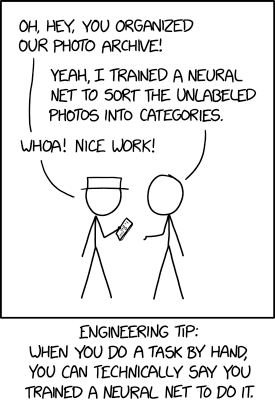

Let's start with a 2 node softmax function

2022-11-30 20:42:10.454827: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-30 20:42:11.238576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
14/14 [==============================] - 2s 118ms/step - loss: 0.7349 - accuracy: 0.6310 - val_loss: 0.6391 - val_accuracy: 0.6722
Epoch 2/10
14/14 [==============================] - 1s 98ms/step - loss: 0.6434 - accuracy: 0.6643 - val_loss: 0.6720 - val_accuracy: 0.6500
Epoch 3/10
14/14 [==============================] - 1s 96ms/step - loss: 0.6526 - accuracy: 0.6643 - val_loss: 0.6391 - val_accuracy: 0.6722
Epoch 4/10
14/14 [==============================] - 1s 96ms/step - loss: 0.6408 - accuracy: 0.6643 - val_loss: 0.6699 - val_accuracy: 0.6667
Epoch 5/10
14/14 [==============================] - 1s 96ms/step - loss: 0.6420 - accuracy: 0.6310 - val_loss: 0.6349 - val_accuracy: 0.6722
Epoch 6/10
14/14 [==============================] - 1s 98ms/step - loss: 0.6475 - accuracy: 0.6643 - val_loss: 0.6448 - val_accuracy: 0.6722
Epoch 7/10
14/14 [==============================] - 1s 95ms/step - loss: 0.6374 - accuracy: 0.6643 - val_loss: 0.6310 - val_accuracy: 0.6722
Epoch 8/10
1

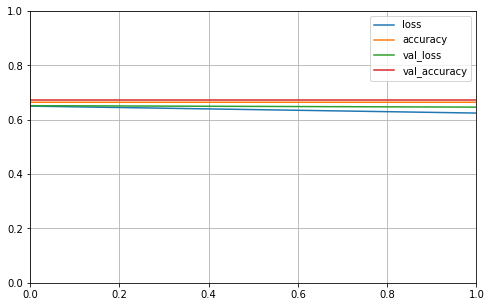

In [10]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt

nn_clf = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[46080]),
    keras.layers.Dense(900, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

nn_clf.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# Round 1
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

# Round 2
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [11]:
train_proba = nn_clf.predict([train_dataset.H1])
test_proba = nn_clf.predict([test_dataset.H1])
print(train_proba.argmax(axis=1))
print(test_proba.argmax(axis=1))
print(test_proba.max(axis=1).round(2))
# So it's predicting 1 for every single answer. That's no good.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Neural network with Sigmoid Function

Epoch 1/10
14/14 [==============================] - 2s 138ms/step - loss: 0.6932 - accuracy: 0.6310 - val_loss: 0.6362 - val_accuracy: 0.6722
Epoch 2/10
14/14 [==============================] - 1s 96ms/step - loss: 0.6490 - accuracy: 0.6643 - val_loss: 0.6270 - val_accuracy: 0.6722
Epoch 3/10
14/14 [==============================] - 1s 99ms/step - loss: 0.6354 - accuracy: 0.6643 - val_loss: 0.7827 - val_accuracy: 0.6722
Epoch 4/10
14/14 [==============================] - 1s 95ms/step - loss: 0.6602 - accuracy: 0.6643 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 5/10
14/14 [==============================] - 1s 95ms/step - loss: 0.6517 - accuracy: 0.6262 - val_loss: 0.6914 - val_accuracy: 0.6722
Epoch 6/10
14/14 [==============================] - 1s 95ms/step - loss: 0.6428 - accuracy: 0.6643 - val_loss: 0.6367 - val_accuracy: 0.6722
Epoch 7/10
14/14 [==============================] - 1s 94ms/step - loss: 0.6366 - accuracy: 0.6643 - val_loss: 0.6562 - val_accuracy: 0.6722
Epoch 8/10
1

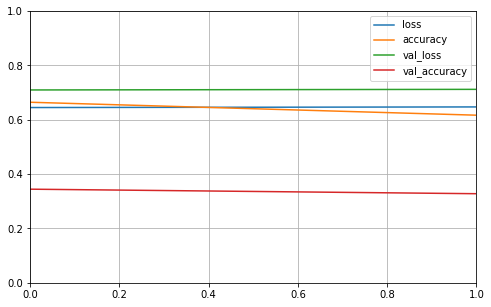

In [12]:
nn_clf = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[46080]),
    keras.layers.Dense(900, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

nn_clf.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# Round 1
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

# Round 2
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [13]:
test_proba = nn_clf.predict([test_dataset.H1])
print(test_proba.argmax(axis=1))
print(test_proba.max(axis=1).round(2))
# Now it's predicting 0 for every single answer. Also not good. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.71 0.7  0.69 0.7  0.69 0.69 0.7  0.7  0.69 0.68 0.68 0.7  0.67 0.68
 0.68 0.68 0.69 0.68 0.68 0.68 0.69 0.68 0.7  0.68 0.7  0.7  0.7  0.69
 0.71 0.69 0.7  0.69 0.71 0.7  0.69 0.69 0.69 0.7  0.71 0.69 0.68 0.67
 0.69 0.72 0.69 0.67 0.67 0.68 0.71 0.71 0.67 0.68 0.69 0.72 0.69 0.64
 0.68 0.7  0.68 0.68 0.71 0.7  0.66 0.67 0.7  0.67 0.69 0.69 0.69 0.68
 0.71 0.69 0.67 0.71 0.69 0.7  0.68 0.67 0.7  0.7  0.72 0.67 0.68 0.68
 0.69 0.67 0.7  0.69 0.71 0.7  0.68 0.68 0.68 0.68 0.68 0.68 0.7  0.7
 0.69 0.68 0.69 0.7  0.67 0.68 0.7  0.69 0.66 0.68 0.72 0.69 0.69 0.71
 0.72 0.7  0.69 0.67 0.71 0.7  0.67 0.69 0.68 0.71 0.69 0.72 0.69 0

# So far we've succeeded 
## in making a very complicated way to assign the same constant to everything
Time to stir the pile


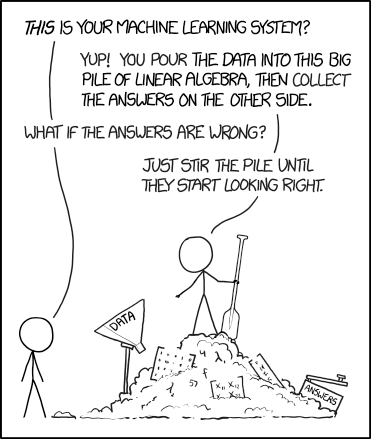